# Проект для «Викишоп»

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Необходимо обучить модель классифицировать комментарии на позитивные и негативные. В распоряжении набор данных с разметкой о токсичности правок.

**Описание данных**

Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Выводы</a></span></li></ul></div>

## Подготовка

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import spacy
import re
import numpy as np

from tqdm.notebook import tqdm
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression, PassiveAggressiveClassifier
from sklearn.metrics import f1_score, confusion_matrix
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.pipeline import Pipeline

In [2]:
toxic_comments = pd.read_csv('/datasets/toxic_comments.csv', index_col=0)
toxic_comments.head()

,text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0


In [3]:
toxic_comments.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 159292 entries, 0 to 159450
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159292 non-null  object
 1   toxic   159292 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.6+ MB


In [4]:
toxic_comments.duplicated().sum()

0

Изучив общую информацию о датасете можем сказать, что в таблице 2 столбца, один с текстом комментария, другой с оценкой токсичности этого комментария, где 0 - комеентарий не токсичен, оценка 1 соответтвует токсичному комментарию. Пропусков в таблице нет. Дубликатов в таблице тоже нет.

Посмотрим на распределение токсичных и нетоксичных комментариев.

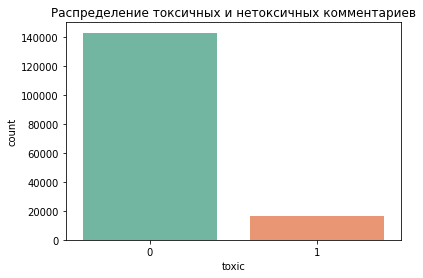

In [5]:
# распределение классов
sns.countplot(x='toxic', data=toxic_comments, palette = "Set2")
plt.title('Распределение токсичных и нетоксичных комментариев')
plt.show()

Большая часть комментариев не токсична, что создаёт дисбаланс классов. При обучении моделей это необходимо учитывать, так как модели могут отдавать предпочтение преобладающему классу (нетоксичным комментариям).

Проведем текс к нижнему регистру и очистим текст от пунктуации. Далее проведем  лемматизацию, чтобы уменьшить количество форм одного и того же слова, что улучшит качество представления текста для модели.

In [6]:
# активируем tqdm для Pandas
tqdm.pandas()

In [7]:
# функция для очистки текста
def clean_text(text):
    text = text.lower()  # приводим к нижнему регистру
    text = re.sub(r'http\S+', '', text)  # удаляем ссылки
    text = re.sub(r'[^a-zA-Z]', ' ', text)  # оставляем только кириллицу
    text = re.sub(r'\s+', ' ', text)  # удаляем лишние пробелы
    return text.strip()

# применяем функцию ко всем комментариям
toxic_comments['cleaned_text'] = toxic_comments['text'].progress_apply(clean_text)

  0%|          | 0/159292 [00:00<?, ?it/s]

In [8]:
# загружаем модель spaCy для английского языка
nlp = spacy.load('en_core_web_sm')

# функция для лемматизации текста
def lemmatize_text_spacy(text):
    doc = nlp(text)
    lemmas = [token.lemma_ for token in doc if not token.is_stop]
    return ' '.join(lemmas)

# применяем функцию к очищенным комментариям
toxic_comments['lemmatized_text'] = toxic_comments['cleaned_text'].progress_apply(lemmatize_text_spacy)
toxic_comments.head()

  0%|          | 0/159292 [00:00<?, ?it/s]

,text,toxic,cleaned_text,lemmatized_text
0,Explanation\nWhy the edits made under my usern...,0,explanation why the edits made under my userna...,explanation edit username hardcore metallica f...
1,D'aww! He matches this background colour I'm s...,0,d aww he matches this background colour i m se...,d aww match background colour m seemingly stuc...
2,"Hey man, I'm really not trying to edit war. It...",0,hey man i m really not trying to edit war it s...,hey man m try edit war s guy constantly remove...
3,"""\nMore\nI can't make any real suggestions on ...",0,more i can t make any real suggestions on impr...,t real suggestion improvement wonder section s...
4,"You, sir, are my hero. Any chance you remember...",0,you sir are my hero any chance you remember wh...,sir hero chance remember page s


In [ ]:
# проверка на наличие пустых строк
empty_rows = toxic_comments['lemmatized_text'].str.strip() == ''
empty_rows.sum()

In [10]:
# заменяем пустые строки на пробелы
toxic_comments['lemmatized_text'] = toxic_comments['lemmatized_text'].replace('', ' ') 

In [11]:
# делим данные на обучающую и тестовую выборки
X = toxic_comments['lemmatized_text']
y = toxic_comments['toxic']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=13, stratify=y)


# проверка распределения классов в выборках
print("Распределение классов в обучающей выборке:")
print(y_train.value_counts(normalize=True))
print("\nРаспределение классов в тестовой выборке:")
print(y_test.value_counts(normalize=True))

Распределение классов в обучающей выборке:
0    0.898386
1    0.101614
Name: toxic, dtype: float64

Распределение классов в тестовой выборке:
0    0.898396
1    0.101604
Name: toxic, dtype: float64


Данные были разделены на обучающую и тестовую выборки с учетом стратификации. Пропорции классов были сохранены в каждой выборке, что позволяет модели лучше адаптироваться к дисбалансу данных.

## Обучение

In [ ]:
# cоздание пайплайна с моделью LogisticRegression
model_log = Pipeline(steps=[
    ('tfidf', TfidfVectorizer(max_features=5000)),
    ('classifier', LogisticRegression(random_state=42, max_iter=10000))
])

# oпределение параметров для оптимизации LogisticRegression
param_grid_log = {
    'classifier__C': [0.1, 1.0, 10.0]
}
# создание объекта GridSearchCV для LogisticRegression
grid_search_log = GridSearchCV(
    model_log,
    param_grid_log,
    scoring='f1',
    verbose=1,
    cv=5
)

# обучение на исходных данных
grid_search_log.fit(X_train, y_train) 

# вывод лучших параметров для LogisticRegression    
print(f"Лучшие параметры для LogisticRegression: {grid_search_log.best_params_}")
# вывод лучшей метрики на кросс-валидации для LogisticRegression 
print(f"Лучший F1-score для LogisticRegression: {grid_search_log.best_score_:.4f}")

Fitting 5 folds for each of 3 candidates, totalling 15 fits


In [ ]:
# cоздание пайплайна с моделью PassiveAggressiveClassifier
model_pac = Pipeline(steps=[
    ('tfidf', TfidfVectorizer(max_features=5000)),
    ('classifier', PassiveAggressiveClassifier(random_state=42, max_iter=10000))
])

# oпределение параметров для оптимизации PassiveAggressiveClassifier
param_grid_pac = {
    'classifier__C': [0.1, 1.0, 10.0],
    'classifier__max_iter': [50, 100]
}
# создание объекта GridSearchCV для PassiveAggressiveClassifier
grid_search_pac = GridSearchCV(
    model_pac,
    param_grid_pac,
    scoring='f1',
    verbose=1,
    cv=5
)

# обучение на исходных данных
grid_search_pac.fit(X_train, y_train)  # Обучаем на исходных данных

# вывод лучших параметров для PassiveAggressiveClassifier     
print(f"Лучшие параметры для PassiveAggressiveClassifier: {grid_search_pac.best_params_}")
# вывод лучшей метрики на кросс-валидации для PassiveAggressiveClassifier
print(f"Лучший F1-score для PassiveAggressiveClassifier: {grid_search_pac.best_score_:.4f}")

Для исследования мы выбрали две модели: логистическая регрессия (LogisticRegression) и PassiveAggressiveClassifier. Для каждой модели был настроен поиск оптимальных гиперпараметров с использованием GridSearchCV и кросс-валидации на 5 фолдах. Для оценки качества использовалась метрика F1.

Лучшие параметры для LogisticRegression: {'classifier__C': 10.0}, F1: 0.7727.

Лучшие параметры для PassiveAggressiveClassifier: {'classifier__C': 0.1, 'classifier__max_iter': 50}, F1: 0.7783.

Обе модели показали достаточно высокий результатБ и приблизительно одинаковый, однако у модели PassiveAggressiveClassifier метрика F1 немного выше, поэтому считаем эту модель лучшей. Проведем оценку тестовых данных лучшей модели.

In [ ]:
# оценка на тестовых данных
best_model = grid_search_pac.best_estimator_
y_pred = best_model.predict(X_test)

f1 = f1_score(y_test, y_pred)
print(f"F1-score модели PassiveAggressiveClassifier на тестовых данных: {f1:.4f}\n")

F1-метрика на тестовой выборке составляет 0.7759 . Это означает, что модель достаточно эффективно определяет токсичные комментарии.

In [ ]:
# построение матрицы ошибок
conf_matrix = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.xlabel('Предсказанные метки')
plt.ylabel('Истинные метки')
plt.title(f'Матрица ошибок для ')
plt.show()

Точность для нетоксичных комментариев составила 97% (28309/(28313+987)), что говорит о высокой вероятности корректной идентификации безопасного контента.

Точность для токсичных комментариев составила 88% (2250/(2250+313)),тоже достаточно хороший результат, это может быть улучшено за счёт дальнейших настроек и увеличения данных для обучения.

## Выводы

В рамках проекта была построена модель, способная с высокой точностью классифицировать токсичные комментарии. Была проведена очистка и лемматизация текста. 

Для исследования были использованы две модели: логистическая регрессия (LogisticRegression) и PassiveAggressiveClassifier. Для каждой модели был настроен поиск оптимальных гиперпараметров с использованием GridSearchCV и кросс-валидации на 5 фолдах. Для оценки качества использовалась метрика F1. Лучшей моделью оказалась PassiveAggressiveClassifier, которая достигла F1-score на уровне  приблизительно 0.78 на тестовой выборке. Это хороший результат для классификации на основе текста, указывающий на то, что модель достаточно точно выявляет токсичные сообщения.

Для поддержания точности модели необходимо регулярно обновлять данные и дообучать модель.